# Import Libraries

In [1]:
import pandas as pd, numpy as np

# Load Dataset
You can download the [data here](https://drive.google.com/file/d/1FoBJB2-dNkRAtqq0Hhc4_tMOpG5kfQD3/view?usp=sharing)

In [6]:
path = '/content/mall_customers.csv'
dataset = pd.read_csv(path)
dataset.columns = ['id', 'gender', 'age', 'income', 'spending']
dataset.head()

,id,gender,age,income,spending
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [8]:
# Missing Values Checking
dataset.isnull().sum()

id          0
gender      0
age         0
income      0
spending    0
dtype: int64

# Statistical Method

## Z-Score

In [ ]:
# z = (i - mean) / std
# z > 3 is outlier

In [34]:
def z_score_outlier (data, z_threshold=3):
    avg = np.average(data)
    std = np.std(data)

    val = 0
    temp = []
    for obs in data:
        z = (obs - avg) / std
        if z > z_threshold:
            temp.append(val)
        val = val + 1
    
    # Return row number
    return temp

In [46]:
row = z_score_outlier(dataset.spending)
dataset.iloc[row,:]

,id,gender,age,income,spending


## IQR

In [40]:
def iqr_outlier (data):
    q1 = np.quantile(data, 0.25)
    q3 = np.quantile(data, 0.75)
    iqr = q3 - q1
    th_above = q3 + iqr
    th_below = q1 - iqr

    val = 0
    temp = []
    for obs in data:
        if obs > th_above:
            temp.append(val)
        elif obs < th_below:
            temp.append(val)
        val = val + 1
    
    # Return row number
    return temp

In [47]:
row = iqr_outlier(dataset.income)
dataset.iloc[row,:]

,id,gender,age,income,spending
194,195,Female,47,120,16
195,196,Female,35,120,79
196,197,Female,45,126,28
197,198,Male,32,126,74
198,199,Male,32,137,18
199,200,Male,30,137,83


## Quantile

In [48]:
def quantile_outlier (data, above=0.99, below=0.01):
    th_above = np.quantile(data, above)
    th_below = np.quantile(data, below)

    val = 0
    temp = []
    for obs in data:
        if obs > th_above:
            temp.append(val)
        elif obs < th_below:
            temp.append(val)
        val = val + 1
    
    # Return row number
    return temp

In [49]:
row = quantile_outlier(dataset.income)
dataset.iloc[row,:]

,id,gender,age,income,spending
0,1,Male,19,15,39
1,2,Male,21,15,81
198,199,Male,32,137,18
199,200,Male,30,137,83


# Proximity Based

In [ ]:
!pip install pyod

In [51]:
from pyod.models.knn import KNN

In [52]:
X = dataset[['age', 'income', 'spending']]

In [64]:
clf_name = 'KNN'
clf = KNN(n_neighbors=7)
clf.fit(X)

KNN(algorithm='auto', contamination=0.1, leaf_size=30, method='largest',
  metric='minkowski', metric_params=None, n_jobs=1, n_neighbors=7, p=2,
  radius=1.0)

In [65]:
# get the prediction labels and outlier scores of the training data
y_train_pred = clf.labels_  # binary labels (0: inliers, 1: outliers)
y_train_scores = clf.decision_scores_  # raw outlier scores

In [66]:
dataset['outlier'] = y_train_pred

### Visualize the outliers

In [67]:
import seaborn as sns, matplotlib.pyplot as plt

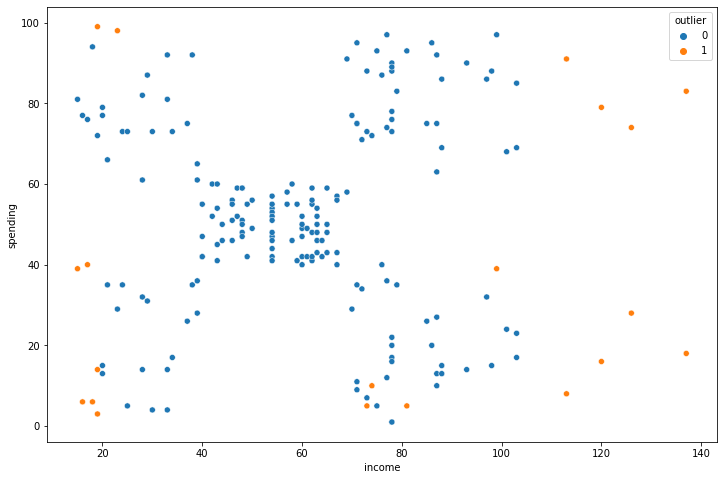

In [68]:
plt.figure(figsize=(12, 8))
sns.scatterplot(data=dataset, x='income', y='spending', hue='outlier')
plt.show()

# Cluster Based

In [81]:
from sklearn.ensemble import IsolationForest

isf = IsolationForest(random_state=0, contamination=0.1)
isf.fit(X)
y_if = isf.predict(X)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  "X does not have valid feature names, but"


In [84]:
dataset['outlier_if'] = y_if

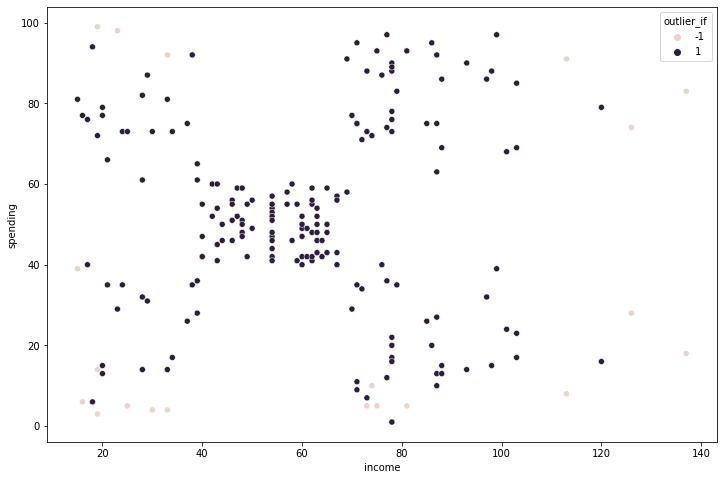

In [85]:
plt.figure(figsize=(12, 8))
sns.scatterplot(data=dataset, x='income', y='spending', hue='outlier_if')
plt.show()

In [86]:
dataset.head()

,id,gender,age,income,spending,outlier,outlier_if
0,1,Male,19,15,39,1,-1
1,2,Male,21,15,81,0,1
2,3,Female,20,16,6,1,-1
3,4,Female,23,16,77,0,1
4,5,Female,31,17,40,1,1


## HDBSCAN

In [87]:
!pip install hdbscan

     |████████████████████████████████| 6.4 MB 12.3 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for hdbscan: filename=hdbscan-0.8.27-cp37-cp37m-linux_x86_64.whl size=2311888 sha256=caa38b4cfe75129836a18e19677f33a06a6472d8e7095d648ad413a1a3a68c46
  Stored in directory: /root/.cache/pip/wheels/73/5f/2f/9a259b84003b84847c259779206acecabb25ab56f1506ee72b
Successfully built hdbscan


In [88]:
from hdbscan import HDBSCAN

hdb = HDBSCAN().fit(X)
hdb_label = hdb.labels_

In [89]:
dataset['cluster_hdb'] = hdb_label

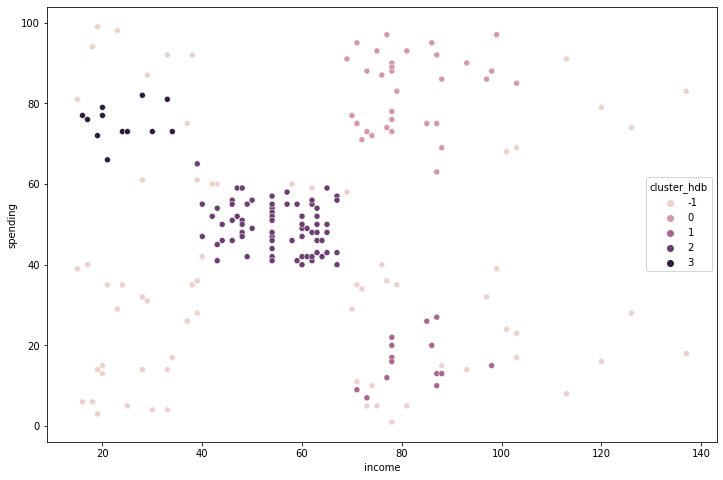

In [90]:
plt.figure(figsize=(12, 8))
sns.scatterplot(data=dataset, x='income', y='spending', hue='cluster_hdb')
plt.show()

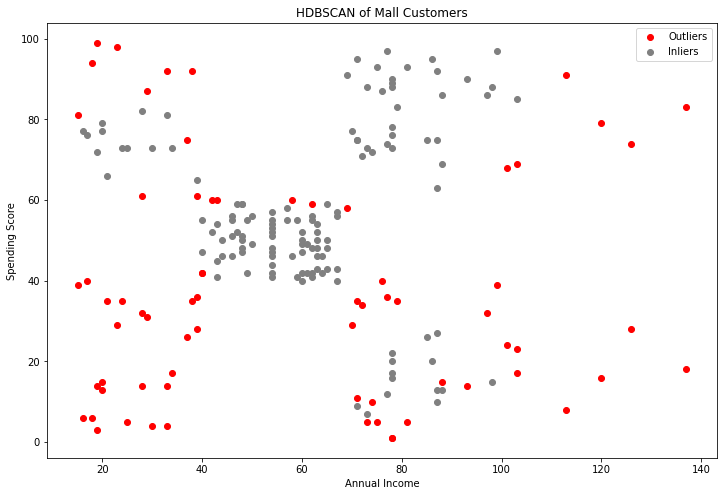

In [91]:
# Visualization
plt.figure(figsize=(12, 8))
plt.scatter(dataset.loc[dataset['cluster_hdb']==-1, 'income'], dataset.loc[dataset['cluster_hdb']==-1, 'spending'], c='red', label='Outliers')
plt.scatter(dataset.loc[dataset['cluster_hdb']!=-1, 'income'], dataset.loc[dataset['cluster_hdb']!=-1, 'spending'], c='grey', label='Inliers')
plt.title('HDBSCAN of Mall Customers')
plt.xlabel('Annual Income')
plt.ylabel('Spending Score')
plt.legend()
plt.show()

# Ensemble Detection

In [98]:
dataset.loc[(dataset.outlier==1) & (dataset.outlier_if==-1) & (dataset.cluster_hdb==-1), 'decision'] = 1
dataset.fillna(0, inplace=True)

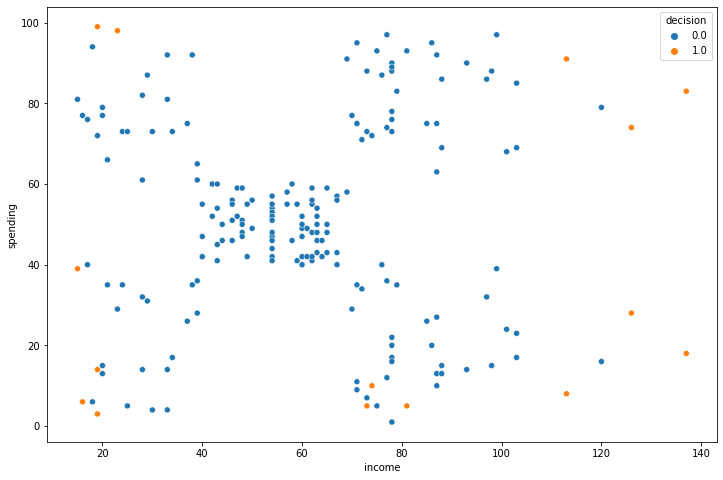

In [100]:
plt.figure(figsize=(12, 8))
sns.scatterplot(data=dataset, x='income', y='spending', hue='decision')
plt.show()